# Predicting Heart Disease

## Introduction

Accordingly to [The World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases) estimates, 17.9 million people die each year from cardiovascular disease (CVD).
Risk factors that can contribute to CVD include: an unhealthy diet, physical inactivity or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

In these project we will be working with [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) and build a K-Nearest Neighbors classifier to predict a patient's likelihood of heart disease in the future.

## Data exploration

We'll start with exploring our dataset. As per the source, each patient has the following information collected about them:

1. Age: age of the patient [years]
0. Sex: sex of the patient [M: Male, F: Female]
0. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
0. RestingBP: resting blood pressure [mm Hg]
0. Cholesterol: serum cholesterol [mm/dl]
0. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
0. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
0. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
0. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
0. Oldpeak: oldpeak = ST [Numeric value measured in depression]
0. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
0. HeartDisease: output class [1: heart disease, 0: Normal]

In [1]:
# importing neccesary libraries
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the dataset in to dataframe
data = pd.read_csv('heart_disease_prediction.csv')

In [3]:
# Looking in to dataset
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Printing out the number of features and observations in the dataset
data.shape

(918, 12)

In [5]:
#checking information about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


From abowe tabe we can see that our data conting both numerical - 7 columns (dtype: **int64**, **float64**) and categorical - 5 columns (dtype: **object**) features. Also we can assume that there are no null values in our dataset but let check it.

`FastingBS` and `HeartDisease` columns have the dtype: **int64**, but are also categorical variables, since they only take the values 0 and 1.

In [6]:
# Checking null values
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

We confirmed that in our dataset there are no missing values.

### EDA: Descriptive Statistics

For now we will focus on numerical features.

In [7]:
# Looking at describe of dataset
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From abowe table, we can observed that:
- the average age of the patients is ~53 years
- `RestingBP` and `Cholesterol` have a minimum value of 0
- `Cholesterol` column has average value of 200 where the maximum value is 600, aslo the median is higher than mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- `Oldpeak` column has average value of ~0.89 where the maximum value is 6.2, indicating that it could be possibility of outliers.

`RestingBP` can't be 0. And, as per the [American Heart Association](RestingBP can't be 0. And, as per the American Heart Association, serum cholesterol is a composite of different measurements. So, it is unlikely that Cholesterol would be 0 as well. We will have to clean both of these up later.), serum cholesterol is a composite of different measurements. So, it is unlikely that `Cholesterol` would be 0 as well. We will have to clean both of these up later.

### EDA: Categorical Data

Now we will take a look on categorical variables. It would also be beneficial to look at how the target feature, `HeartDisease`, is related to those categories.

In [8]:
# Looking at describe of dataset for dtyepe object
data.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [9]:
data['HeartDisease'].unique(), data['FastingBS'].unique()

(array([0, 1]), array([0, 1]))

We can cofirm that those columns are categorical looking at the number of unique values in each of them. But, we can't gather much else. Also, FastingBS and HeartDisease are categorical as well since they only contain binary values.

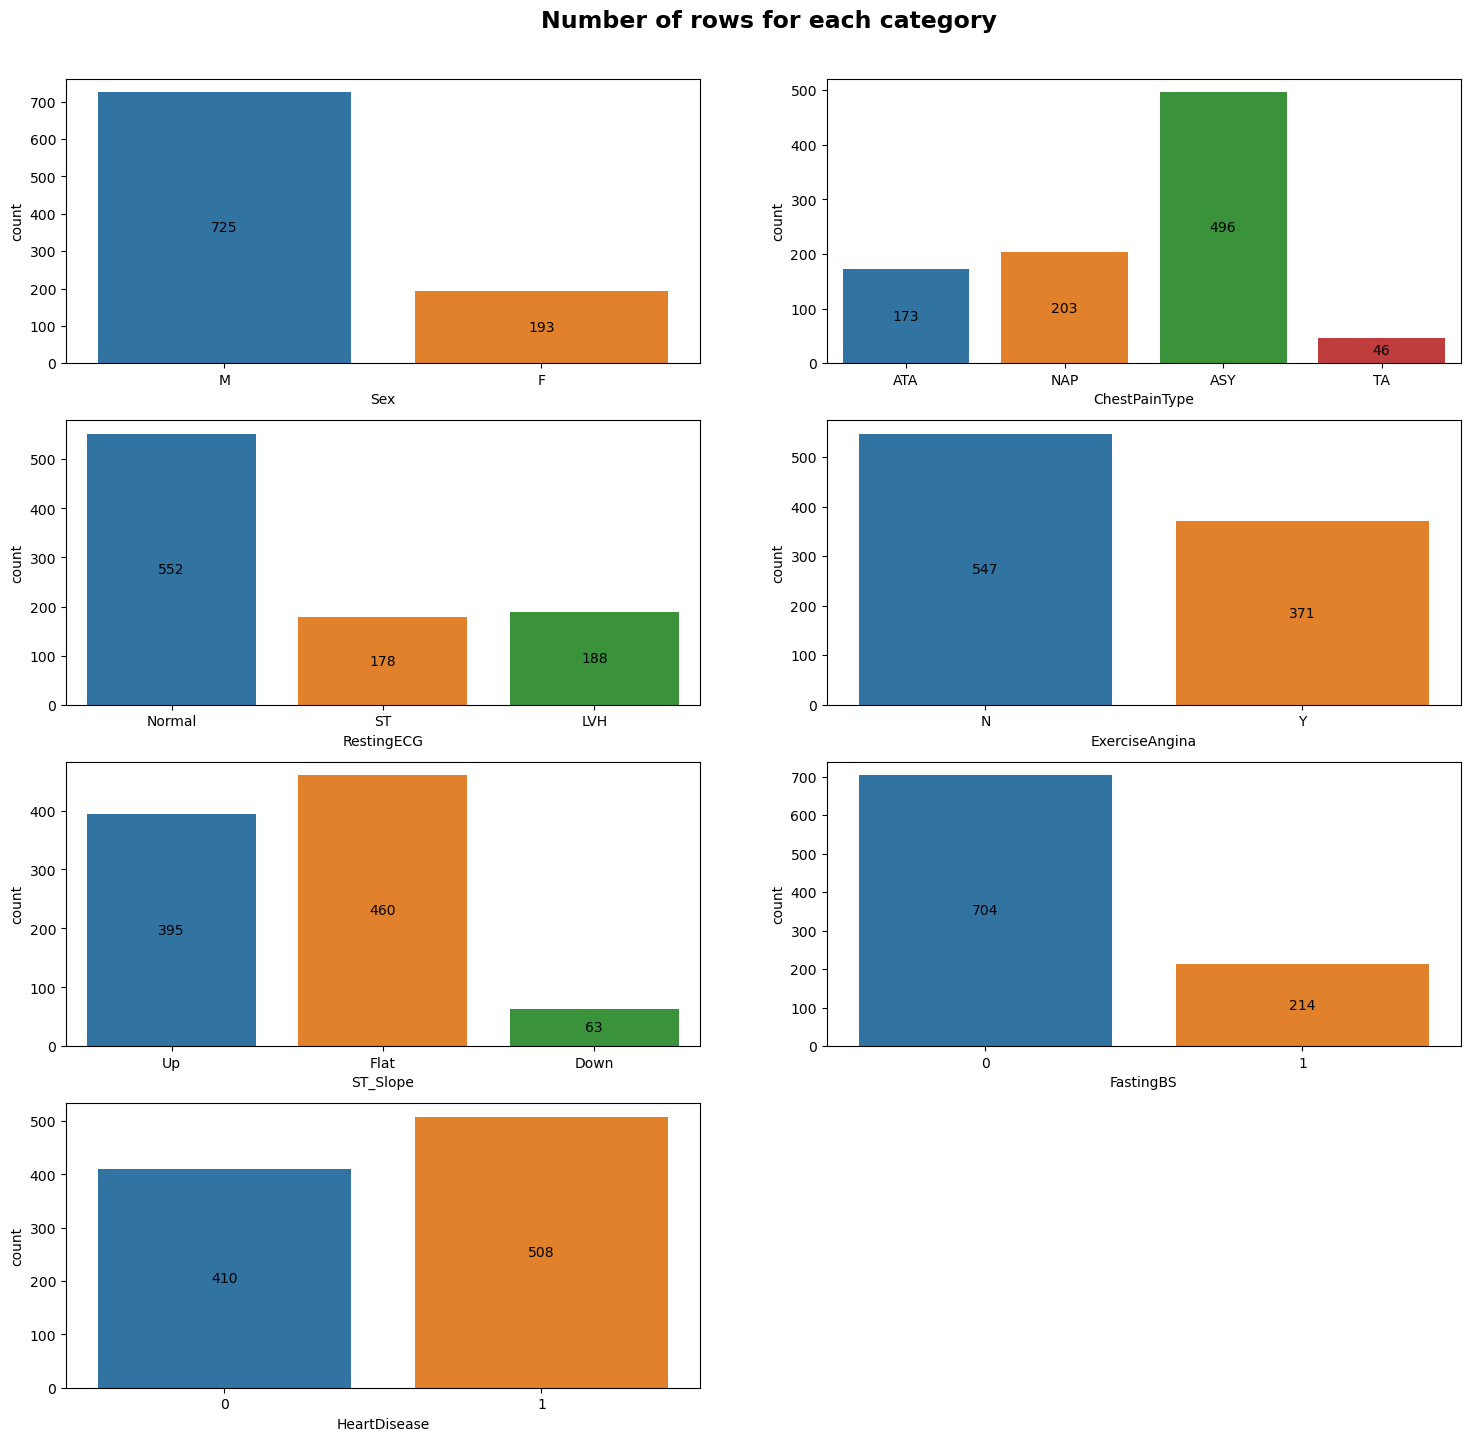

In [10]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 
                       'ST_Slope', 'FastingBS', 'HeartDisease']


fig = plt.figure(figsize=(18,17))

for idx, col in enumerate(categorical_columns):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=data[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")
        
ax.text(1, 2550,'Number of rows for each category', size=17, weight='bold')
plt.show()

From abowe charts, we can observed that:
- there are 725 male patients and 193 female patients (this could potentially induce a bias in our model)
- 496 patients had ASY (asymptotic) chest pain type.
- 552 patients had a normal restin ECG.
- 704 patients had blood sugar lower than 120 mg/dl
- 508 patients had heart disease

Now we will group these by `HeartDisease`. It will give us a better idea about the data distribution.

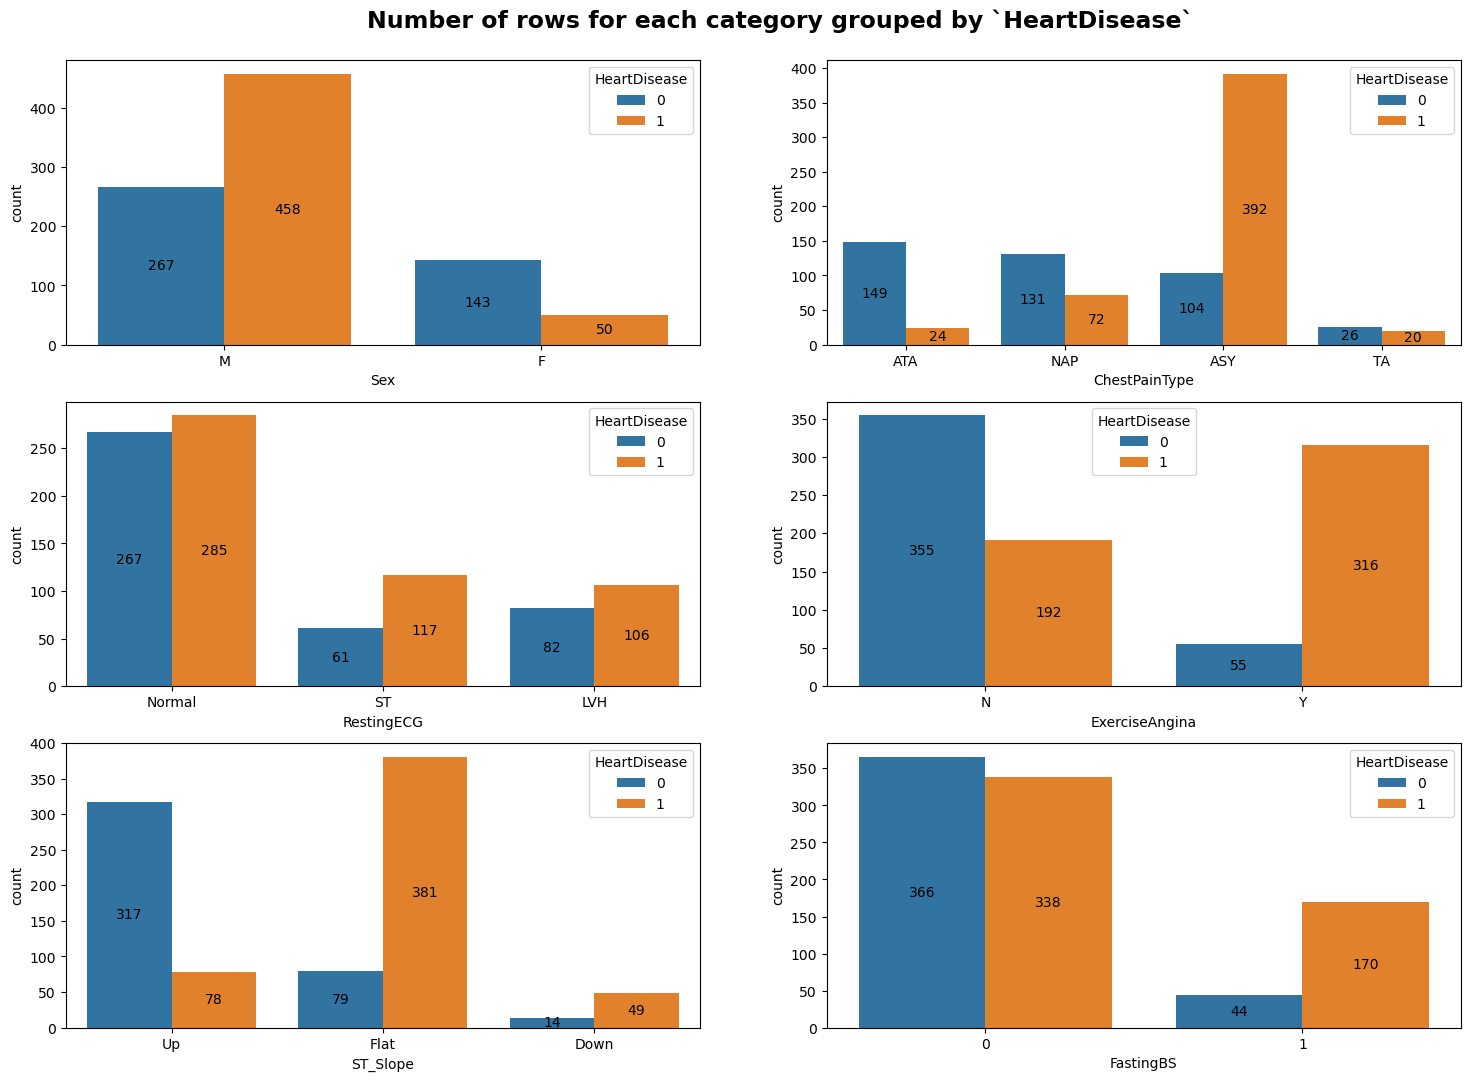

In [11]:
fig = plt.figure(figsize=(18,17))

for idx, col in enumerate(categorical_columns[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=data[col], hue=data["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")
        
ax.text(-1.95, 1350,'Number of rows for each category grouped by `HeartDisease`', size=17, weight='bold')
plt.show()

Looking at the charts we can see that:
- only 50 female patients in the dataset have been diagnosed with heart disease
- 392 patients diagnosed with heart disease have asymptomatic (ASY) chest pain
- 170 of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease
- out of all patients who had an exercise-induced angina, 316 were diagnosed with a heart disease.
- out of all patients with a flat ST slope, 381 were diagnosed with a heart disease.

From above plots, we can start to identify some features that could be relevant to us.

Now we will create new dataframe in with we select only data for patients who have heart disease and we're going to find answers for below questions:
- What percentage of patients with heart disease are male and over 50 years old?
- What is the median age of patients who were diagnosed with heart disease?

In [12]:
# Creating dataframe with patients who have heart disease
heart_disease = data[data['HeartDisease'] == 1]

First we will find  the median age of patients who were diagnosed with heart disease.

In [13]:
heart_disease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.0
mean,55.899606,134.185039,175.940945,0.334646,127.655512,1.274213,1.0
std,8.727056,19.828685,126.391398,0.472332,23.386923,1.151872,0.0
min,31.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,1.0
25%,51.000000,120.000000,0.000000,0.000000,112.000000,0.000000,1.0
50%,57.000000,132.000000,217.000000,0.000000,126.000000,1.200000,1.0
75%,62.000000,145.000000,267.000000,1.000000,144.250000,2.000000,1.0
max,77.000000,200.000000,603.000000,1.000000,195.000000,6.200000,1.0


As we can see in abowe tabel:
- the median age of patients who were diagnosed with heart disease is 57
- the mean age of patients who were diagnosed with heart disease is ~56

Now we will answer the question: what percentage of patients with heart disease are male and over 50 years old? We strat with finding the percentage of male patients. 

In [14]:
# Percentage of patients with hear disease accoringly to sex
heart_disease['Sex'].value_counts(normalize=True)

M    0.901575
F    0.098425
Name: Sex, dtype: float64

From abowe we see that 90% of patients with heart disease are male and only ~10% are female. Let now check how many patients are male and over 50 years old.

In [15]:
# Selecting patients over 50 years old
over_50 = heart_disease[heart_disease['Age'] > 50]

In [16]:
# Percentage of patients over 50 years old with hear disease accoringly to sex
over_50['Sex'].value_counts(normalize=True)

M    0.898172
F    0.101828
Name: Sex, dtype: float64

From abowe we see that ~90% of patients with heart disease are male over 50 years old and only 10% are female. Lets check for patients befor 50.

In [17]:
# Selecting patients before 50 years old
before_50 = heart_disease[heart_disease['Age'] <= 50]

In [18]:
# Percentage of patients before 50 years old with hear disease accoringly to sex
before_50['Sex'].value_counts(normalize=True)

M    0.912
F    0.088
Name: Sex, dtype: float64

As we can see for batients before 50 years old the percentage are similar to patients over 50 years old: 91% are male and ~9% are female.

Looking at that analysis we can assume that low number of female are diagnosed with hear disease. We will clean up the dataset a bit first before narrowing down on our features.

## Data Cleaning

Earlier in our analysis we check that there are no missing values in our datacheck. Also we noticed that a couple of columns have 0 values which don't make sense.

There are a few ways we can handle with these values:
- we could remove those rows entirely if their frequency of occurrence is low,
- we could impute those zeros with the median value of that column or the median value of the column grouped by `HeartDisease`
- we could try some complex approaches.

Now we will look at how many zero values `RestingBP` and `Cholesterol` contain and decide how to handle those.

In [19]:
# Counting numbers of rows that have 0 value
data[data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [20]:
data[data['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


As we can see in abowe tabels:
- `RestingBP` column has only one zero value so we can remove that row. 
- `Cholesterol` column has 172 zero values. That's a relatively high number so we can't remove them all without risking loosing to many data.

We'll replace the zero values in `Cholesterol` in relation to `HeartDisease`. So, the 0 values in `Cholesterol` for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [21]:
# Copied dataset to new datafreame 
data_clean = data.copy()

# Keep non-zero values for RestingBP
data_clean = data_clean[data_clean["RestingBP"] != 0]

# Creating a mask for HearDisease
heartdisease_mask = data_clean['HeartDisease'] == 0

# Creating two new datasets depending to heartdisease
cholesterol_without_heartdisease = data_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = data_clean.loc[~heartdisease_mask, "Cholesterol"]

# Clening performing using mask and two new daframes
data_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
data_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

In [22]:
# Check after cleaning
data_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


In abowe tabel we see that minimum value for `Cholesterol` and `RestingBP` change and there are no more zero values.

## Feature Selection

Now that we have cleared our data, we can select features for our model.  we can identify some of the features that we could start with:
- Age
- Sex
- ChestPainType
- Cholesterol
- FastingBS

We will also identify how stronly the feature columns are correlated to the target colummn. That should help us narrow down on the features.

In order to do that, we will first convert our categorical columns into dummy variables.

In [23]:
# Convert the categorical features into dummy variables
data_clean = pd.get_dummies(data_clean, drop_first=True)
data_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


Now we'll look for correlations between them.

<AxesSubplot:>

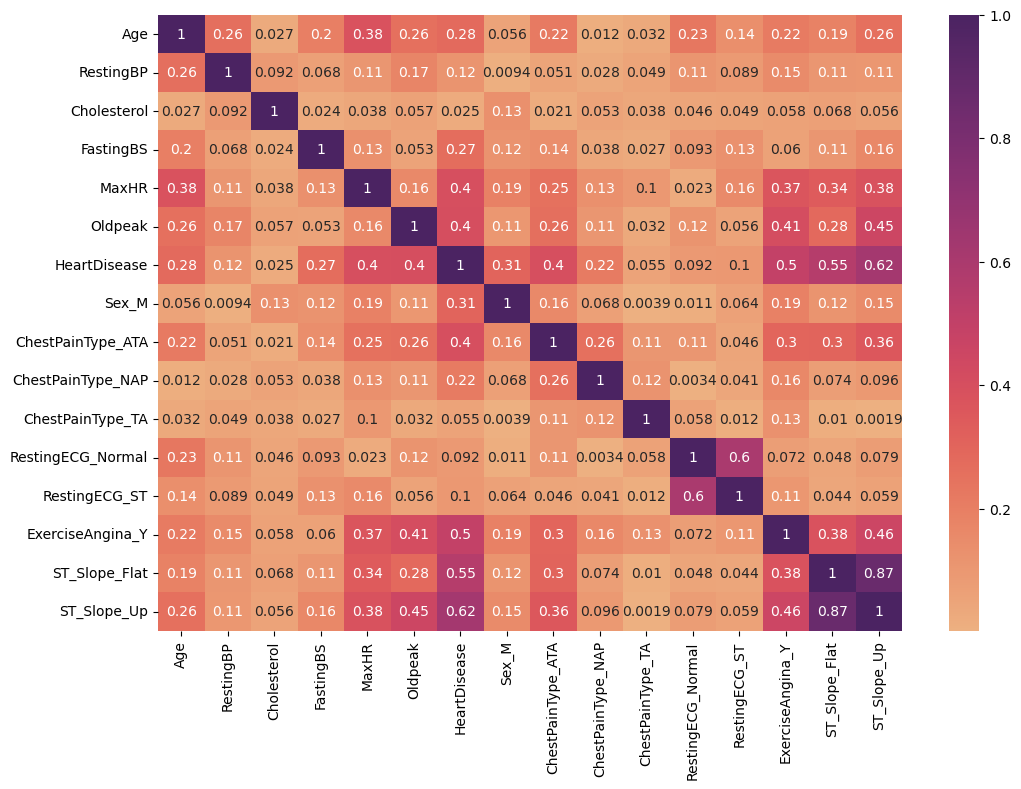

In [24]:
# Create a Pearson's correlation heat map.
correlation = abs(data_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlation, annot=True, cmap="flare")

We will modify the heat map to see only pars with correlation coefficient is greater than 0.3.

<AxesSubplot:>

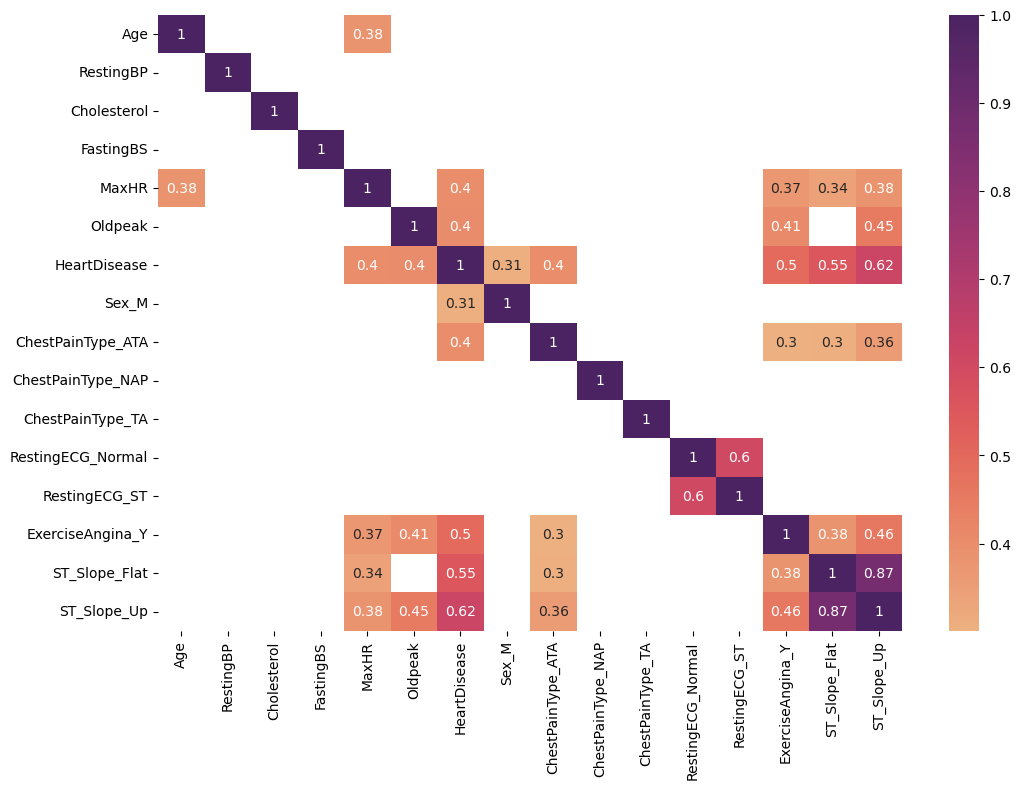

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(correlation[correlation > 0.3], annot=True, cmap="flare")

From our correlation heat map, we can identify the following features to be positively correlated to `HeartDisease`:
- MaxHR
- Oldpeak
- Sex_M
- ChestPainType_ATA
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_UP

Surprisingly, `Cholesterol` is not strongly correlated to `HeartDisease` so we can ignoring the feature for now.

Given everything we have attempted so far, we can narrow down our features to the following:
- Sex_M (it has a relatively low value for the coefficient, but given what we observed in our EDA, let's also take it into account)
- ChestPainType_ATA
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_UP

Now we will create our model using these features.ex_M (it has a relatively low value for the coefficient, but given what we observed in our EDA, let's also take it into account)
ChestPainType_ATA
ExerciseAngina_Y
ST_Slope_Flat
ST_Slope_Up

## Building Classifiers

### Building a Classifier with One Feature

We will store the feature columns in the variable X and the target column in the variable y. Then we split our dataset into a training, validation and a test set first.

In [26]:
# Store feature columns and target column in the variables
X = data_clean.drop(['HeartDisease'], axis=1)
y = data_clean['HeartDisease']

In [27]:
# Spliting dataset into a training, validation and a test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=417)

In [28]:
# Creating a list that contains features
features = [
            'Sex_M', 
            'ChestPainType_ATA', 
            'ExerciseAngina_Y', 
            'ST_Slope_Flat', 
            'ST_Slope_Up'
            ]

We will start with creating a model for each of the features above and evaluate their performance using accuracy as a metric.

In [29]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 10 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Sex_M and with k = 10 has an accuracy of 65.76%
The k-NN classifier trained on ChestPainType_ATA and with k = 10 has an accuracy of 44.02%
The k-NN classifier trained on ExerciseAngina_Y and with k = 10 has an accuracy of 71.20%
The k-NN classifier trained on ST_Slope_Flat and with k = 10 has an accuracy of 78.26%
The k-NN classifier trained on ST_Slope_Up and with k = 10 has an accuracy of 80.98%


Our best forming model, with an accuracy of ~81%, was trained on the ST_Slope_Up feature with ST_Slope_Flat being a close second.

We will train a model using all of these features next.

### Building a Classifier with Multiple Features

Now we will train a model on all features together. Before that, we need to normalize the data first. We will use `scikit-learn's MinMaxScaler` to scale the values between 0 and 1, and then train the model again.

In [30]:
# Creating a scaler
scaler = MinMaxScaler()
# Fit and transform the features in training set
X_train_scaled = scaler.fit_transform(X_train[features])
# Transforming features in validation set
X_val_scaled = scaler.transform(X_val[features])

In [31]:
# Creating a k-NN model
knn = KNeighborsClassifier(n_neighbors=10)
# Fiting the model to trainig data
knn.fit(X_train_scaled, y_train)
# Accuracy of the model
accuracy = knn.score(X_val_scaled, y_val)
print(f'Model accuracy for chosen features on validation set: {accuracy*100:.2f}%')

Model accuracy for chosen features on validation set: 82.07%


The model's accuracy jumped to ~82%! That's not a significant improvement, but still a good start. Using all these features results in an improved model, but, let's see what parameters/hyperparameters might be optimal.

## Hyperparameter Tuning

Now that we have a reasonably well-performing model, we can experiment with the parameters and hyperparameters. We'll use `GridSearchCV` to search over those values.

Let's start with preparing data.

In [32]:
# Store feature columns and target column in the variables
X = data_clean.drop(['HeartDisease'], axis=1)
y = data_clean['HeartDisease']
# Spliting dataset into a training, validation and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=417)
# Creating a list that contains features
features = [
            'Sex_M', 
            'ChestPainType_ATA', 
            'ExerciseAngina_Y', 
            'ST_Slope_Flat', 
            'ST_Slope_Up'
            ]
# Creating a scaler
scaler = MinMaxScaler()
# Fit and transform the features in training set
X_train_scaled = scaler.fit_transform(X_train[features])

We will use grid search to explore the following range of values for a couple of hyperparameters:
- for k (n_neighbors in scikit-learn) we will use values in the range of 1 to 10.
- we will use two distance metrics - minkwoski and manhattan.

`minkwoski` is the default metric for `KNeighborsClassifier` in `sklearn`, so we don't expect `manhattan` to do better. But, let's see the results.

In [33]:
# Creating dictionary that stores the parameters and values to search over as key-value pairs
grid_params = {"n_neighbors": range(1, 10),
                "metric": ["minkowski", "manhattan"]
              }
# Initialize the k-NN model
knn = KNeighborsClassifier()
# Create a `GridSearchCV` instance
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
# Fiting instance on the scaled features and corresponding labels
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 10)},
             scoring='accuracy')

In [34]:
# The best score and the best parameters obtained from the grid search
knn_grid.best_score_*100, knn_grid.best_params_

(83.48336594911939, {'metric': 'minkowski', 'n_neighbors': 5})

Our best model had an accuracy of ~83% with 5 `n_neighbors` and `minkowski` as the distance metric.

The accuracy of this model is only slightly better. Since `GridSearchCV` employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

We will evaluate our model on our test set now.

## Model Evaluation on Test Set

First we need to  normalize our test set similar to how we scaled our training set.

In [37]:
X_test_scaled = scaler.transform(X_test[features])

Now we will predict the model's output on the scaled features from the test set using the best estimate.

In [38]:
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 85.87


Our model got an accuracy of ~86%. This means that our model is likely to correctly predict whether a patient is at risk for a heart disease ~86% of the time.

However, the accuracy being higher than the one before raises some flags.

One explanation that could explain is to look at how the data is distributed.  Earlier we observed that more men were represented in the dataset and this may introduce bias. Lets take a closer look to that.

In [39]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
1    724
0    193
Name: Sex_M, dtype: int64

Distribution of patients by their sex in the training dataset
1    580
0    153
Name: Sex_M, dtype: int64

Distribution of patients by their sex in the test dataset
1    144
0     40
Name: Sex_M, dtype: int64


We used `Sex_M` as one of our features for training the model.
- X had 724 males and 193 females.
- X_train had 580 males and 153 females.
- X_test had 144 males and 40 females.

We can see that the above datasets have a significantly higher number of male patients than female ones. We can see it potentially impacts our model. If the test dataset doesn't have that many female patients and the model was trained on a dataset with more male patients, then it is understandable it has better accuracy on the test set. Of course, there could be other factors contributing to this discrepancy.

## Summary

Our final model was trained using the following features:
- Sex_M
- ChestPainType_ATA
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_UP

and had a test set accuracy of 85.87%. However, given the limitations of our data this accuracy might not be indicative of a well performing model.

There are quite a few things we could try next to get better results:
- try with different features,
- expand the grid search parameters to identify more optimal hyperparameters,
- explore other algorithms that might perform better than k-NN,
- try and collect more data.